# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 topics most highly correlated with GDP growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast GDP growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 topics (<=2007, 200 topics, all sources).
- **Forecast Target:** GDP growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'GDP'                             # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
       
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"
        
        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11502
EM iteration 50, llf=-11251, convergence criterion=1.8402e-06
EM converged at iteration 67, llf=-11251, convergence criterion=9.9816e-07 < tolerance=1e-06
EM start iterations, llf=-11514
EM iteration 50, llf=-11264, convergence criterion=1.8384e-06
EM converged at iteration 67, llf=-11263, convergence criterion=9.9712e-07 < tolerance=1e-06
EM start iterations, llf=-11567
EM iteration 50, llf=-11313, convergence criterion=1.8394e-06
EM converged at iteration 67, llf=-11313, convergence criterion=9.9857e-07 < tolerance=1e-06
EM start iterations, llf=-11575
EM iteration 50, llf=-11322, convergence criterion=1.8282e-06
EM converged at iteration 67, llf=-11321, convergence criterion=9.9117e-07 < tolerance=1e-06
EM start iterations, llf=-11639
EM iteration 50, llf=-11381, convergence criterion=1.8087e-06
EM converged at iteration 67, llf=-11380, convergence criterion=9.8188e-07 < tolerance=1e-06
EM start iterations, llf=-11648
EM iteration 50, llf=-11388, conv

EM start iterations, llf=-12547
EM converged at iteration 47, llf=-12330, convergence criterion=9.5741e-07 < tolerance=1e-06
EM start iterations, llf=-12601
EM converged at iteration 46, llf=-12391, convergence criterion=9.6881e-07 < tolerance=1e-06
EM start iterations, llf=-12601
EM converged at iteration 46, llf=-12391, convergence criterion=9.6881e-07 < tolerance=1e-06
EM start iterations, llf=-12612
EM converged at iteration 45, llf=-12405, convergence criterion=9.9836e-07 < tolerance=1e-06
EM start iterations, llf=-12661
EM converged at iteration 46, llf=-12451, convergence criterion=9.7961e-07 < tolerance=1e-06
EM start iterations, llf=-12672
EM iteration 50, llf=-12463, convergence criterion=1.0199e-06
EM converged at iteration 51, llf=-12463, convergence criterion=9.8065e-07 < tolerance=1e-06
EM start iterations, llf=-12722
EM iteration 50, llf=-12509, convergence criterion=1.0237e-06
EM converged at iteration 51, llf=-12509, convergence criterion=9.8424e-07 < tolerance=1e-06
E

EM converged at iteration 49, llf=-13704, convergence criterion=9.9638e-07 < tolerance=1e-06
EM start iterations, llf=-13943
EM converged at iteration 49, llf=-13747, convergence criterion=9.9136e-07 < tolerance=1e-06
EM start iterations, llf=-13955
EM converged at iteration 49, llf=-13761, convergence criterion=9.8354e-07 < tolerance=1e-06
EM start iterations, llf=-14004
EM iteration 50, llf=-13810, convergence criterion=9.9033e-07
EM converged at iteration 50, llf=-13810, convergence criterion=9.9033e-07 < tolerance=1e-06
EM start iterations, llf=-14010
EM iteration 50, llf=-13811, convergence criterion=1.0258e-06
EM converged at iteration 51, llf=-13811, convergence criterion=9.885e-07 < tolerance=1e-06
EM start iterations, llf=-14048
EM iteration 50, llf=-13844, convergence criterion=9.9956e-07
EM converged at iteration 50, llf=-13844, convergence criterion=9.9956e-07 < tolerance=1e-06
EM start iterations, llf=-14048
EM iteration 50, llf=-13844, convergence criterion=9.9956e-07
EM 

EM start iterations, llf=-14953
EM iteration 50, llf=-14730, convergence criterion=1.0033e-06
EM converged at iteration 51, llf=-14730, convergence criterion=9.6331e-07 < tolerance=1e-06
EM start iterations, llf=-15147
EM iteration 50, llf=-14921, convergence criterion=9.7409e-07
EM converged at iteration 50, llf=-14921, convergence criterion=9.7409e-07 < tolerance=1e-06
EM start iterations, llf=-15156
EM iteration 50, llf=-14931, convergence criterion=9.6811e-07
EM converged at iteration 50, llf=-14931, convergence criterion=9.6811e-07 < tolerance=1e-06
EM start iterations, llf=-15630
EM converged at iteration 46, llf=-15414, convergence criterion=9.7756e-07 < tolerance=1e-06
EM start iterations, llf=-15635
EM converged at iteration 46, llf=-15420, convergence criterion=9.7616e-07 < tolerance=1e-06
EM start iterations, llf=-15682
EM converged at iteration 46, llf=-15466, convergence criterion=9.7975e-07 < tolerance=1e-06
EM start iterations, llf=-15682
EM converged at iteration 46, ll

EM converged at iteration 42, llf=-16948, convergence criterion=9.5993e-07 < tolerance=1e-06
EM start iterations, llf=-17177
EM converged at iteration 42, llf=-16956, convergence criterion=9.712e-07 < tolerance=1e-06
EM start iterations, llf=-17217
EM converged at iteration 42, llf=-16996, convergence criterion=9.6805e-07 < tolerance=1e-06
EM start iterations, llf=-17225
EM converged at iteration 42, llf=-16999, convergence criterion=9.8941e-07 < tolerance=1e-06
EM start iterations, llf=-17274
EM converged at iteration 42, llf=-17049, convergence criterion=9.9122e-07 < tolerance=1e-06
EM start iterations, llf=-17274
EM converged at iteration 42, llf=-17049, convergence criterion=9.9122e-07 < tolerance=1e-06
EM start iterations, llf=-17284
EM converged at iteration 42, llf=-17061, convergence criterion=9.8569e-07 < tolerance=1e-06
EM start iterations, llf=-17336
EM converged at iteration 42, llf=-17110, convergence criterion=9.8121e-07 < tolerance=1e-06
EM start iterations, llf=-17344
E

EM start iterations, llf=-18645
EM converged at iteration 43, llf=-18401, convergence criterion=9.8309e-07 < tolerance=1e-06
EM start iterations, llf=-18696
EM converged at iteration 43, llf=-18450, convergence criterion=9.8641e-07 < tolerance=1e-06
EM start iterations, llf=-18696
EM converged at iteration 43, llf=-18450, convergence criterion=9.8641e-07 < tolerance=1e-06
EM start iterations, llf=-18703
EM converged at iteration 43, llf=-18459, convergence criterion=9.8076e-07 < tolerance=1e-06
EM start iterations, llf=-18757
EM converged at iteration 43, llf=-18513, convergence criterion=9.7066e-07 < tolerance=1e-06
EM start iterations, llf=-18766
EM converged at iteration 42, llf=-18522, convergence criterion=9.9661e-07 < tolerance=1e-06
EM start iterations, llf=-18820
EM converged at iteration 42, llf=-18575, convergence criterion=9.9536e-07 < tolerance=1e-06
EM start iterations, llf=-18827
EM converged at iteration 42, llf=-18581, convergence criterion=9.9507e-07 < tolerance=1e-06


EM start iterations, llf=-12261
EM iteration 50, llf=-12062, convergence criterion=1.2128e-06
EM converged at iteration 55, llf=-12062, convergence criterion=9.853e-07 < tolerance=1e-06
EM start iterations, llf=-12290
EM iteration 50, llf=-12089, convergence criterion=1.1842e-06
EM converged at iteration 55, llf=-12089, convergence criterion=9.6385e-07 < tolerance=1e-06
EM start iterations, llf=-12290
EM iteration 50, llf=-12089, convergence criterion=1.1842e-06
EM converged at iteration 55, llf=-12089, convergence criterion=9.6385e-07 < tolerance=1e-06
EM start iterations, llf=-12297
EM iteration 50, llf=-12088, convergence criterion=1.1896e-06
EM converged at iteration 55, llf=-12088, convergence criterion=9.6103e-07 < tolerance=1e-06
EM start iterations, llf=-12334
EM iteration 50, llf=-12121, convergence criterion=1.1184e-06
EM converged at iteration 53, llf=-12121, convergence criterion=9.7868e-07 < tolerance=1e-06
EM start iterations, llf=-12333
EM iteration 50, llf=-12116, conve

EM start iterations, llf=-13400
EM iteration 50, llf=-13203, convergence criterion=1.768e-06
EM converged at iteration 68, llf=-13202, convergence criterion=9.9779e-07 < tolerance=1e-06
EM start iterations, llf=-13410
EM iteration 50, llf=-13217, convergence criterion=1.8955e-06
EM converged at iteration 72, llf=-13217, convergence criterion=9.9678e-07 < tolerance=1e-06
EM start iterations, llf=-13453
EM iteration 50, llf=-13263, convergence criterion=1.922e-06
EM converged at iteration 76, llf=-13262, convergence criterion=9.7902e-07 < tolerance=1e-06
EM start iterations, llf=-13461
EM iteration 50, llf=-13269, convergence criterion=1.9693e-06
EM converged at iteration 74, llf=-13269, convergence criterion=9.8081e-07 < tolerance=1e-06
EM start iterations, llf=-13505
EM iteration 50, llf=-13311, convergence criterion=1.9389e-06
EM converged at iteration 72, llf=-13310, convergence criterion=9.9059e-07 < tolerance=1e-06
EM start iterations, llf=-13516
EM iteration 50, llf=-13323, conver

EM start iterations, llf=-14487
EM iteration 50, llf=-14282, convergence criterion=1.6529e-06
EM converged at iteration 67, llf=-14282, convergence criterion=9.9254e-07 < tolerance=1e-06
EM start iterations, llf=-14494
EM iteration 50, llf=-14290, convergence criterion=1.6597e-06
EM converged at iteration 67, llf=-14289, convergence criterion=9.9806e-07 < tolerance=1e-06
EM start iterations, llf=-14543
EM iteration 50, llf=-14336, convergence criterion=1.5911e-06
EM converged at iteration 65, llf=-14336, convergence criterion=9.9263e-07 < tolerance=1e-06
EM start iterations, llf=-14557
EM iteration 50, llf=-14352, convergence criterion=1.6014e-06
EM converged at iteration 66, llf=-14351, convergence criterion=9.7542e-07 < tolerance=1e-06
EM start iterations, llf=-14612
EM iteration 50, llf=-14412, convergence criterion=1.4712e-06
EM converged at iteration 71, llf=-14412, convergence criterion=9.8926e-07 < tolerance=1e-06
EM start iterations, llf=-14612
EM iteration 50, llf=-14412, conv

EM start iterations, llf=-15629
EM iteration 50, llf=-15405, convergence criterion=1.367e-06
EM converged at iteration 60, llf=-15405, convergence criterion=9.7802e-07 < tolerance=1e-06
EM start iterations, llf=-15634
EM iteration 50, llf=-15411, convergence criterion=1.3715e-06
EM converged at iteration 60, llf=-15411, convergence criterion=9.8245e-07 < tolerance=1e-06
EM start iterations, llf=-15680
EM iteration 50, llf=-15457, convergence criterion=1.3682e-06
EM converged at iteration 60, llf=-15457, convergence criterion=9.8127e-07 < tolerance=1e-06
EM start iterations, llf=-15680
EM iteration 50, llf=-15457, convergence criterion=1.3682e-06
EM converged at iteration 60, llf=-15457, convergence criterion=9.8127e-07 < tolerance=1e-06
EM start iterations, llf=-15692
EM iteration 50, llf=-15470, convergence criterion=1.3537e-06
EM converged at iteration 60, llf=-15470, convergence criterion=9.7416e-07 < tolerance=1e-06
EM start iterations, llf=-15745
EM iteration 50, llf=-15524, conve

EM start iterations, llf=-16757
EM iteration 50, llf=-16525, convergence criterion=1.1361e-06
EM converged at iteration 54, llf=-16525, convergence criterion=9.9119e-07 < tolerance=1e-06
EM start iterations, llf=-16757
EM iteration 50, llf=-16525, convergence criterion=1.1361e-06
EM converged at iteration 54, llf=-16525, convergence criterion=9.9119e-07 < tolerance=1e-06
EM start iterations, llf=-16766
EM iteration 50, llf=-16535, convergence criterion=1.1252e-06
EM converged at iteration 54, llf=-16535, convergence criterion=9.8331e-07 < tolerance=1e-06
EM start iterations, llf=-16818
EM iteration 50, llf=-16587, convergence criterion=1.1022e-06
EM converged at iteration 53, llf=-16587, convergence criterion=9.952e-07 < tolerance=1e-06
EM start iterations, llf=-16825
EM iteration 50, llf=-16594, convergence criterion=1.1359e-06
EM converged at iteration 54, llf=-16594, convergence criterion=9.9398e-07 < tolerance=1e-06
EM start iterations, llf=-16877
EM iteration 50, llf=-16646, conve

EM start iterations, llf=-17824
EM iteration 50, llf=-17587, convergence criterion=1.1147e-06
EM converged at iteration 54, llf=-17587, convergence criterion=9.7046e-07 < tolerance=1e-06
EM start iterations, llf=-17877
EM iteration 50, llf=-17640, convergence criterion=1.1116e-06
EM converged at iteration 54, llf=-17640, convergence criterion=9.6854e-07 < tolerance=1e-06
EM start iterations, llf=-17884
EM iteration 50, llf=-17643, convergence criterion=1.1116e-06
EM converged at iteration 53, llf=-17643, convergence criterion=9.9936e-07 < tolerance=1e-06
EM start iterations, llf=-17926
EM iteration 50, llf=-17683, convergence criterion=1.1011e-06
EM converged at iteration 53, llf=-17683, convergence criterion=9.8847e-07 < tolerance=1e-06
EM start iterations, llf=-17940
EM iteration 50, llf=-17700, convergence criterion=1.1024e-06
EM converged at iteration 53, llf=-17700, convergence criterion=9.9088e-07 < tolerance=1e-06
EM start iterations, llf=-17788
EM iteration 50, llf=-17542, conv

EM start iterations, llf=-18764
EM iteration 50, llf=-18512, convergence criterion=1.1065e-06
EM converged at iteration 53, llf=-18512, convergence criterion=9.919e-07 < tolerance=1e-06
EM start iterations, llf=-18819
EM iteration 50, llf=-18565, convergence criterion=1.1026e-06
EM converged at iteration 53, llf=-18565, convergence criterion=9.8836e-07 < tolerance=1e-06
EM start iterations, llf=-18825
EM iteration 50, llf=-18571, convergence criterion=1.102e-06
EM converged at iteration 53, llf=-18571, convergence criterion=9.8783e-07 < tolerance=1e-06
EM start iterations, llf=-18872
EM iteration 50, llf=-18617, convergence criterion=1.0929e-06
EM converged at iteration 53, llf=-18617, convergence criterion=9.7892e-07 < tolerance=1e-06
EM start iterations, llf=-18872
EM iteration 50, llf=-18617, convergence criterion=1.0929e-06
EM converged at iteration 53, llf=-18617, convergence criterion=9.7892e-07 < tolerance=1e-06
EM start iterations, llf=-18599
EM iteration 50, llf=-18344, conver

EM converged at iteration 57, llf=-12016, convergence criterion=9.7817e-07 < tolerance=1e-06
EM start iterations, llf=-12254
EM iteration 50, llf=-12055, convergence criterion=1.3845e-06
EM converged at iteration 58, llf=-12055, convergence criterion=9.7904e-07 < tolerance=1e-06
EM start iterations, llf=-12283
EM iteration 50, llf=-12083, convergence criterion=1.3584e-06
EM converged at iteration 58, llf=-12083, convergence criterion=9.6396e-07 < tolerance=1e-06
EM start iterations, llf=-12283
EM iteration 50, llf=-12083, convergence criterion=1.3584e-06
EM converged at iteration 58, llf=-12083, convergence criterion=9.6396e-07 < tolerance=1e-06
EM start iterations, llf=-12291
EM iteration 50, llf=-12081, convergence criterion=1.3029e-06
EM converged at iteration 56, llf=-12081, convergence criterion=9.9582e-07 < tolerance=1e-06
EM start iterations, llf=-12328
EM iteration 50, llf=-12113, convergence criterion=1.2055e-06
EM converged at iteration 55, llf=-12113, convergence criterion=9

EM converged at iteration 64, llf=-13197, convergence criterion=9.692e-07 < tolerance=1e-06
EM start iterations, llf=-13391
EM iteration 50, llf=-13198, convergence criterion=1.6303e-06
EM converged at iteration 64, llf=-13197, convergence criterion=9.692e-07 < tolerance=1e-06
EM start iterations, llf=-13401
EM iteration 50, llf=-13212, convergence criterion=1.686e-06
EM converged at iteration 64, llf=-13212, convergence criterion=9.9269e-07 < tolerance=1e-06
EM start iterations, llf=-13444
EM iteration 50, llf=-13257, convergence criterion=1.6617e-06
EM converged at iteration 64, llf=-13257, convergence criterion=9.8679e-07 < tolerance=1e-06
EM start iterations, llf=-13452
EM iteration 50, llf=-13264, convergence criterion=1.7725e-06
EM converged at iteration 66, llf=-13264, convergence criterion=9.9098e-07 < tolerance=1e-06
EM start iterations, llf=-13497
EM iteration 50, llf=-13305, convergence criterion=1.7947e-06
EM converged at iteration 66, llf=-13305, convergence criterion=9.99

EM converged at iteration 64, llf=-14234, convergence criterion=9.7804e-07 < tolerance=1e-06
EM start iterations, llf=-14478
EM iteration 50, llf=-14277, convergence criterion=1.628e-06
EM converged at iteration 64, llf=-14277, convergence criterion=9.7263e-07 < tolerance=1e-06
EM start iterations, llf=-14486
EM iteration 50, llf=-14285, convergence criterion=1.642e-06
EM converged at iteration 64, llf=-14285, convergence criterion=9.7921e-07 < tolerance=1e-06
EM start iterations, llf=-14535
EM iteration 50, llf=-14331, convergence criterion=1.6042e-06
EM converged at iteration 63, llf=-14331, convergence criterion=9.9289e-07 < tolerance=1e-06
EM start iterations, llf=-14550
EM iteration 50, llf=-14347, convergence criterion=1.6219e-06
EM converged at iteration 64, llf=-14346, convergence criterion=9.6984e-07 < tolerance=1e-06
EM start iterations, llf=-14603
EM iteration 50, llf=-14408, convergence criterion=1.6461e-06
EM converged at iteration 64, llf=-14407, convergence criterion=9.8

EM converged at iteration 66, llf=-14915, convergence criterion=9.7106e-07 < tolerance=1e-06
EM start iterations, llf=-15620
EM iteration 50, llf=-15399, convergence criterion=1.5166e-06
EM converged at iteration 62, llf=-15399, convergence criterion=9.6869e-07 < tolerance=1e-06
EM start iterations, llf=-15625
EM iteration 50, llf=-15405, convergence criterion=1.5242e-06
EM converged at iteration 62, llf=-15405, convergence criterion=9.731e-07 < tolerance=1e-06
EM start iterations, llf=-15672
EM iteration 50, llf=-15451, convergence criterion=1.5226e-06
EM converged at iteration 62, llf=-15451, convergence criterion=9.7231e-07 < tolerance=1e-06
EM start iterations, llf=-15672
EM iteration 50, llf=-15451, convergence criterion=1.5226e-06
EM converged at iteration 62, llf=-15451, convergence criterion=9.7231e-07 < tolerance=1e-06
EM start iterations, llf=-15684
EM iteration 50, llf=-15464, convergence criterion=1.5103e-06
EM converged at iteration 61, llf=-15464, convergence criterion=9.

EM converged at iteration 57, llf=-16464, convergence criterion=9.8603e-07 < tolerance=1e-06
EM start iterations, llf=-16749
EM iteration 50, llf=-16519, convergence criterion=1.2922e-06
EM converged at iteration 57, llf=-16519, convergence criterion=9.8513e-07 < tolerance=1e-06
EM start iterations, llf=-16749
EM iteration 50, llf=-16519, convergence criterion=1.2922e-06
EM converged at iteration 57, llf=-16519, convergence criterion=9.8513e-07 < tolerance=1e-06
EM start iterations, llf=-16757
EM iteration 50, llf=-16529, convergence criterion=1.2821e-06
EM converged at iteration 57, llf=-16529, convergence criterion=9.7836e-07 < tolerance=1e-06
EM start iterations, llf=-16809
EM iteration 50, llf=-16581, convergence criterion=1.267e-06
EM converged at iteration 57, llf=-16581, convergence criterion=9.6728e-07 < tolerance=1e-06
EM start iterations, llf=-16816
EM iteration 50, llf=-16588, convergence criterion=1.3009e-06
EM converged at iteration 57, llf=-16588, convergence criterion=9.

EM converged at iteration 57, llf=-17567, convergence criterion=9.7239e-07 < tolerance=1e-06
EM start iterations, llf=-17816
EM iteration 50, llf=-17581, convergence criterion=1.2683e-06
EM converged at iteration 57, llf=-17581, convergence criterion=9.6925e-07 < tolerance=1e-06
EM start iterations, llf=-17869
EM iteration 50, llf=-17634, convergence criterion=1.2558e-06
EM converged at iteration 56, llf=-17634, convergence criterion=9.9525e-07 < tolerance=1e-06
EM start iterations, llf=-17876
EM iteration 50, llf=-17636, convergence criterion=1.2564e-06
EM converged at iteration 56, llf=-17636, convergence criterion=9.9466e-07 < tolerance=1e-06
EM start iterations, llf=-17918
EM iteration 50, llf=-17677, convergence criterion=1.2541e-06
EM converged at iteration 56, llf=-17676, convergence criterion=9.9184e-07 < tolerance=1e-06
EM start iterations, llf=-17932
EM iteration 50, llf=-17694, convergence criterion=1.2509e-06
EM converged at iteration 56, llf=-17694, convergence criterion=9

EM converged at iteration 55, llf=-18496, convergence criterion=9.9983e-07 < tolerance=1e-06
EM start iterations, llf=-18755
EM iteration 50, llf=-18505, convergence criterion=1.2054e-06
EM converged at iteration 55, llf=-18505, convergence criterion=9.8686e-07 < tolerance=1e-06
EM start iterations, llf=-18809
EM iteration 50, llf=-18558, convergence criterion=1.2085e-06
EM converged at iteration 55, llf=-18558, convergence criterion=9.8952e-07 < tolerance=1e-06
EM start iterations, llf=-18816
EM iteration 50, llf=-18564, convergence criterion=1.2076e-06
EM converged at iteration 55, llf=-18564, convergence criterion=9.8875e-07 < tolerance=1e-06
EM start iterations, llf=-18863
EM iteration 50, llf=-18610, convergence criterion=1.1851e-06
EM converged at iteration 55, llf=-18610, convergence criterion=9.7061e-07 < tolerance=1e-06
EM start iterations, llf=-18863
EM iteration 50, llf=-18610, convergence criterion=1.1851e-06
EM converged at iteration 55, llf=-18610, convergence criterion=9

EM start iterations, llf=-11801
EM converged at iteration 40, llf=-11642, convergence criterion=9.5633e-07 < tolerance=1e-06
EM start iterations, llf=-11850
EM converged at iteration 40, llf=-11691, convergence criterion=9.6072e-07 < tolerance=1e-06
EM start iterations, llf=-11850
EM converged at iteration 40, llf=-11691, convergence criterion=9.6072e-07 < tolerance=1e-06
EM start iterations, llf=-11850
EM converged at iteration 40, llf=-11692, convergence criterion=9.6977e-07 < tolerance=1e-06
EM start iterations, llf=-11886
EM converged at iteration 41, llf=-11731, convergence criterion=9.7304e-07 < tolerance=1e-06
EM start iterations, llf=-11899
EM converged at iteration 36, llf=-11742, convergence criterion=9.7889e-07 < tolerance=1e-06
EM start iterations, llf=-11940
EM converged at iteration 36, llf=-11786, convergence criterion=9.4661e-07 < tolerance=1e-06
EM start iterations, llf=-11955
EM converged at iteration 35, llf=-11801, convergence criterion=9.9347e-07 < tolerance=1e-06


EM start iterations, llf=-13350
EM converged at iteration 36, llf=-13187, convergence criterion=9.795e-07 < tolerance=1e-06
EM start iterations, llf=-13413
EM converged at iteration 36, llf=-13250, convergence criterion=9.7272e-07 < tolerance=1e-06
EM start iterations, llf=-13419
EM converged at iteration 37, llf=-13256, convergence criterion=9.8285e-07 < tolerance=1e-06
EM start iterations, llf=-13467
EM converged at iteration 36, llf=-13305, convergence criterion=9.8378e-07 < tolerance=1e-06
EM start iterations, llf=-13476
EM converged at iteration 37, llf=-13314, convergence criterion=9.8033e-07 < tolerance=1e-06
EM start iterations, llf=-13524
EM converged at iteration 37, llf=-13361, convergence criterion=9.5972e-07 < tolerance=1e-06
EM start iterations, llf=-13524
EM converged at iteration 37, llf=-13361, convergence criterion=9.5972e-07 < tolerance=1e-06
EM start iterations, llf=-13530
EM converged at iteration 37, llf=-13369, convergence criterion=9.539e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15036
EM converged at iteration 32, llf=-14870, convergence criterion=9.9706e-07 < tolerance=1e-06
EM start iterations, llf=-15041
EM converged at iteration 32, llf=-14875, convergence criterion=9.9704e-07 < tolerance=1e-06
EM start iterations, llf=-15095
EM converged at iteration 33, llf=-14929, convergence criterion=9.4194e-07 < tolerance=1e-06
EM start iterations, llf=-15095
EM converged at iteration 33, llf=-14929, convergence criterion=9.4194e-07 < tolerance=1e-06
EM start iterations, llf=-15105
EM converged at iteration 33, llf=-14939, convergence criterion=9.4131e-07 < tolerance=1e-06
EM start iterations, llf=-15153
EM converged at iteration 33, llf=-14987, convergence criterion=9.3953e-07 < tolerance=1e-06
EM start iterations, llf=-15162
EM converged at iteration 33, llf=-14996, convergence criterion=9.4688e-07 < tolerance=1e-06
EM start iterations, llf=-15206
EM converged at iteration 33, llf=-15039, convergence criterion=9.5045e-07 < tolerance=1e-06


EM start iterations, llf=-16622
EM converged at iteration 31, llf=-16456, convergence criterion=9.4693e-07 < tolerance=1e-06
EM start iterations, llf=-16629
EM converged at iteration 31, llf=-16463, convergence criterion=9.5325e-07 < tolerance=1e-06
EM start iterations, llf=-16678
EM converged at iteration 31, llf=-16511, convergence criterion=9.4255e-07 < tolerance=1e-06
EM start iterations, llf=-16687
EM converged at iteration 31, llf=-16519, convergence criterion=9.6923e-07 < tolerance=1e-06
EM start iterations, llf=-16736
EM converged at iteration 31, llf=-16569, convergence criterion=9.6427e-07 < tolerance=1e-06
EM start iterations, llf=-16745
EM converged at iteration 31, llf=-16577, convergence criterion=9.6744e-07 < tolerance=1e-06
EM start iterations, llf=-16797
EM converged at iteration 31, llf=-16629, convergence criterion=9.5957e-07 < tolerance=1e-06
EM start iterations, llf=-16797
EM converged at iteration 31, llf=-16629, convergence criterion=9.5957e-07 < tolerance=1e-06


EM start iterations, llf=-17762
EM converged at iteration 29, llf=-17599, convergence criterion=9.8051e-07 < tolerance=1e-06
EM start iterations, llf=-17815
EM converged at iteration 29, llf=-17652, convergence criterion=9.8706e-07 < tolerance=1e-06
EM start iterations, llf=-17819
EM converged at iteration 29, llf=-17656, convergence criterion=9.8615e-07 < tolerance=1e-06
EM start iterations, llf=-17875
EM converged at iteration 29, llf=-17712, convergence criterion=9.7742e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 1 estimated in 1:23:56.711973.
EM start iterations, llf=-11016
EM iteration 50, llf=-10861, convergence criterion=1.9325e-06
EM converged at iteration 73, llf=-10860, convergence criterion=9.8723e-07 < tolerance=1e-06
EM start iterations, llf=-11029
EM iteration 50, llf=-10873, convergence criterion=1.9304e-06
EM converged at iteration 73, llf=-10873, convergence criterion=9.8521e-07 < tolerance=1e-06
EM start iterations, llf=-11080
EM iteration 50,

EM converged at iteration 41, llf=-11791, convergence criterion=9.5688e-07 < tolerance=1e-06
EM start iterations, llf=-11985
EM converged at iteration 41, llf=-11828, convergence criterion=9.9216e-07 < tolerance=1e-06
EM start iterations, llf=-11985
EM converged at iteration 41, llf=-11828, convergence criterion=9.9216e-07 < tolerance=1e-06
EM start iterations, llf=-11993
EM converged at iteration 41, llf=-11835, convergence criterion=9.9658e-07 < tolerance=1e-06
EM start iterations, llf=-12041
EM converged at iteration 41, llf=-11885, convergence criterion=9.9195e-07 < tolerance=1e-06
EM start iterations, llf=-12047
EM converged at iteration 41, llf=-11891, convergence criterion=9.8706e-07 < tolerance=1e-06
EM start iterations, llf=-12097
EM converged at iteration 41, llf=-11941, convergence criterion=9.6594e-07 < tolerance=1e-06
EM start iterations, llf=-12110
EM converged at iteration 41, llf=-11952, convergence criterion=9.7338e-07 < tolerance=1e-06
EM start iterations, llf=-12157


EM start iterations, llf=-13523
EM converged at iteration 41, llf=-13357, convergence criterion=9.8257e-07 < tolerance=1e-06
EM start iterations, llf=-13577
EM converged at iteration 40, llf=-13411, convergence criterion=9.792e-07 < tolerance=1e-06
EM start iterations, llf=-13588
EM converged at iteration 40, llf=-13423, convergence criterion=9.737e-07 < tolerance=1e-06
EM start iterations, llf=-13635
EM converged at iteration 40, llf=-13471, convergence criterion=9.8478e-07 < tolerance=1e-06
EM start iterations, llf=-13647
EM converged at iteration 40, llf=-13481, convergence criterion=9.7806e-07 < tolerance=1e-06
EM start iterations, llf=-13697
EM converged at iteration 40, llf=-13530, convergence criterion=9.7416e-07 < tolerance=1e-06
EM start iterations, llf=-13697
EM converged at iteration 40, llf=-13530, convergence criterion=9.7416e-07 < tolerance=1e-06
EM start iterations, llf=-13702
EM converged at iteration 40, llf=-13535, convergence criterion=9.7253e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15198
EM converged at iteration 36, llf=-15026, convergence criterion=9.9399e-07 < tolerance=1e-06
EM start iterations, llf=-15206
EM converged at iteration 36, llf=-15034, convergence criterion=9.9063e-07 < tolerance=1e-06
EM start iterations, llf=-15254
EM converged at iteration 36, llf=-15082, convergence criterion=9.8583e-07 < tolerance=1e-06
EM start iterations, llf=-15254
EM converged at iteration 36, llf=-15082, convergence criterion=9.8583e-07 < tolerance=1e-06
EM start iterations, llf=-15265
EM converged at iteration 36, llf=-15092, convergence criterion=9.8373e-07 < tolerance=1e-06
EM start iterations, llf=-15308
EM converged at iteration 36, llf=-15136, convergence criterion=9.8515e-07 < tolerance=1e-06
EM start iterations, llf=-15316
EM converged at iteration 34, llf=-15145, convergence criterion=9.7755e-07 < tolerance=1e-06
EM start iterations, llf=-15364
EM converged at iteration 34, llf=-15193, convergence criterion=9.6985e-07 < tolerance=1e-06


EM start iterations, llf=-16789
EM converged at iteration 35, llf=-16616, convergence criterion=9.854e-07 < tolerance=1e-06
EM start iterations, llf=-16795
EM converged at iteration 35, llf=-16622, convergence criterion=9.774e-07 < tolerance=1e-06
EM start iterations, llf=-16842
EM converged at iteration 35, llf=-16670, convergence criterion=9.7256e-07 < tolerance=1e-06
EM start iterations, llf=-16857
EM converged at iteration 35, llf=-16683, convergence criterion=9.834e-07 < tolerance=1e-06
EM start iterations, llf=-16909
EM converged at iteration 35, llf=-16736, convergence criterion=9.9098e-07 < tolerance=1e-06
EM start iterations, llf=-16916
EM converged at iteration 35, llf=-16743, convergence criterion=9.9453e-07 < tolerance=1e-06
EM start iterations, llf=-16959
EM converged at iteration 36, llf=-16784, convergence criterion=9.4803e-07 < tolerance=1e-06
EM start iterations, llf=-16959
EM converged at iteration 36, llf=-16784, convergence criterion=9.4803e-07 < tolerance=1e-06
EM 

EM converged at iteration 85, llf=-10859, convergence criterion=9.9604e-07 < tolerance=1e-06
EM start iterations, llf=-11070
EM iteration 50, llf=-10911, convergence criterion=2.1643e-06
EM converged at iteration 81, llf=-10910, convergence criterion=9.9055e-07 < tolerance=1e-06
EM start iterations, llf=-11079
EM iteration 50, llf=-10920, convergence criterion=2.1045e-06
EM converged at iteration 80, llf=-10920, convergence criterion=9.8662e-07 < tolerance=1e-06
EM start iterations, llf=-11136
EM iteration 50, llf=-10978, convergence criterion=2.0376e-06
EM converged at iteration 77, llf=-10977, convergence criterion=9.8473e-07 < tolerance=1e-06
EM start iterations, llf=-11147
EM iteration 50, llf=-10987, convergence criterion=2.0328e-06
EM converged at iteration 76, llf=-10986, convergence criterion=9.9356e-07 < tolerance=1e-06
EM start iterations, llf=-11204
EM iteration 50, llf=-11039, convergence criterion=2.0279e-06
EM converged at iteration 76, llf=-11039, convergence criterion=9

EM converged at iteration 60, llf=-11726, convergence criterion=9.8932e-07 < tolerance=1e-06
EM start iterations, llf=-11928
EM iteration 50, llf=-11770, convergence criterion=1.4435e-06
EM converged at iteration 63, llf=-11769, convergence criterion=9.7996e-07 < tolerance=1e-06
EM start iterations, llf=-11944
EM iteration 50, llf=-11784, convergence criterion=1.3841e-06
EM converged at iteration 61, llf=-11784, convergence criterion=9.8874e-07 < tolerance=1e-06
EM start iterations, llf=-11980
EM iteration 50, llf=-11822, convergence criterion=1.4612e-06
EM converged at iteration 64, llf=-11821, convergence criterion=9.8296e-07 < tolerance=1e-06
EM start iterations, llf=-11980
EM iteration 50, llf=-11822, convergence criterion=1.4612e-06
EM converged at iteration 64, llf=-11821, convergence criterion=9.8296e-07 < tolerance=1e-06
EM start iterations, llf=-11988
EM iteration 50, llf=-11828, convergence criterion=1.4305e-06
EM converged at iteration 63, llf=-11828, convergence criterion=9

EM converged at iteration 62, llf=-12781, convergence criterion=9.9052e-07 < tolerance=1e-06
EM start iterations, llf=-12986
EM iteration 50, llf=-12820, convergence criterion=1.4022e-06
EM converged at iteration 61, llf=-12820, convergence criterion=9.826e-07 < tolerance=1e-06
EM start iterations, llf=-12986
EM iteration 50, llf=-12820, convergence criterion=1.4022e-06
EM converged at iteration 61, llf=-12820, convergence criterion=9.826e-07 < tolerance=1e-06
EM start iterations, llf=-12998
EM iteration 50, llf=-12832, convergence criterion=1.412e-06
EM converged at iteration 61, llf=-12832, convergence criterion=9.9012e-07 < tolerance=1e-06
EM start iterations, llf=-13045
EM iteration 50, llf=-12878, convergence criterion=1.4073e-06
EM converged at iteration 61, llf=-12878, convergence criterion=9.8689e-07 < tolerance=1e-06
EM start iterations, llf=-13051
EM iteration 50, llf=-12886, convergence criterion=1.3236e-06
EM converged at iteration 59, llf=-12885, convergence criterion=9.87

EM converged at iteration 55, llf=-13860, convergence criterion=9.8187e-07 < tolerance=1e-06
EM start iterations, llf=-14036
EM iteration 50, llf=-13868, convergence criterion=1.1743e-06
EM converged at iteration 55, llf=-13868, convergence criterion=9.7931e-07 < tolerance=1e-06
EM start iterations, llf=-14084
EM iteration 50, llf=-13916, convergence criterion=1.1872e-06
EM converged at iteration 55, llf=-13916, convergence criterion=9.9048e-07 < tolerance=1e-06
EM start iterations, llf=-14092
EM iteration 50, llf=-13924, convergence criterion=1.185e-06
EM converged at iteration 55, llf=-13924, convergence criterion=9.8853e-07 < tolerance=1e-06
EM start iterations, llf=-14138
EM iteration 50, llf=-13971, convergence criterion=1.1889e-06
EM converged at iteration 55, llf=-13970, convergence criterion=9.9164e-07 < tolerance=1e-06
EM start iterations, llf=-14146
EM iteration 50, llf=-13978, convergence criterion=1.1793e-06
EM converged at iteration 55, llf=-13978, convergence criterion=9.

EM converged at iteration 53, llf=-14966, convergence criterion=9.995e-07 < tolerance=1e-06
EM start iterations, llf=-15147
EM iteration 50, llf=-14975, convergence criterion=1.1158e-06
EM converged at iteration 54, llf=-14975, convergence criterion=9.6887e-07 < tolerance=1e-06
EM start iterations, llf=-15191
EM iteration 50, llf=-15018, convergence criterion=1.1204e-06
EM converged at iteration 54, llf=-15018, convergence criterion=9.727e-07 < tolerance=1e-06
EM start iterations, llf=-15198
EM iteration 50, llf=-15026, convergence criterion=1.1171e-06
EM converged at iteration 54, llf=-15026, convergence criterion=9.6985e-07 < tolerance=1e-06
EM start iterations, llf=-15247
EM iteration 50, llf=-15074, convergence criterion=1.1156e-06
EM converged at iteration 54, llf=-15074, convergence criterion=9.6765e-07 < tolerance=1e-06
EM start iterations, llf=-15247
EM iteration 50, llf=-15074, convergence criterion=1.1156e-06
EM converged at iteration 54, llf=-15074, convergence criterion=9.6

EM converged at iteration 53, llf=-16017, convergence criterion=9.9e-07 < tolerance=1e-06
EM start iterations, llf=-16198
EM iteration 50, llf=-16026, convergence criterion=1.0991e-06
EM converged at iteration 53, llf=-16026, convergence criterion=9.9004e-07 < tolerance=1e-06
EM start iterations, llf=-16245
EM iteration 50, llf=-16072, convergence criterion=1.1131e-06
EM converged at iteration 54, llf=-16072, convergence criterion=9.7044e-07 < tolerance=1e-06
EM start iterations, llf=-16245
EM iteration 50, llf=-16072, convergence criterion=1.1131e-06
EM converged at iteration 54, llf=-16072, convergence criterion=9.7044e-07 < tolerance=1e-06
EM start iterations, llf=-16264
EM iteration 50, llf=-16092, convergence criterion=1.112e-06
EM converged at iteration 54, llf=-16092, convergence criterion=9.6946e-07 < tolerance=1e-06
EM start iterations, llf=-16314
EM iteration 50, llf=-16142, convergence criterion=1.0968e-06
EM converged at iteration 53, llf=-16142, convergence criterion=9.879

EM converged at iteration 51, llf=-16927, convergence criterion=9.9565e-07 < tolerance=1e-06
EM start iterations, llf=-17099
EM iteration 50, llf=-16927, convergence criterion=1.0333e-06
EM converged at iteration 51, llf=-16927, convergence criterion=9.9565e-07 < tolerance=1e-06
EM start iterations, llf=-17104
EM iteration 50, llf=-16932, convergence criterion=1.0285e-06
EM converged at iteration 51, llf=-16932, convergence criterion=9.91e-07 < tolerance=1e-06
EM start iterations, llf=-17152
EM iteration 50, llf=-16980, convergence criterion=9.9857e-07
EM converged at iteration 50, llf=-16980, convergence criterion=9.9857e-07 < tolerance=1e-06
EM start iterations, llf=-17162
EM iteration 50, llf=-16989, convergence criterion=1.0201e-06
EM converged at iteration 51, llf=-16989, convergence criterion=9.8241e-07 < tolerance=1e-06
EM start iterations, llf=-17212
EM iteration 50, llf=-17039, convergence criterion=1.0185e-06
EM converged at iteration 51, llf=-17039, convergence criterion=9.8

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


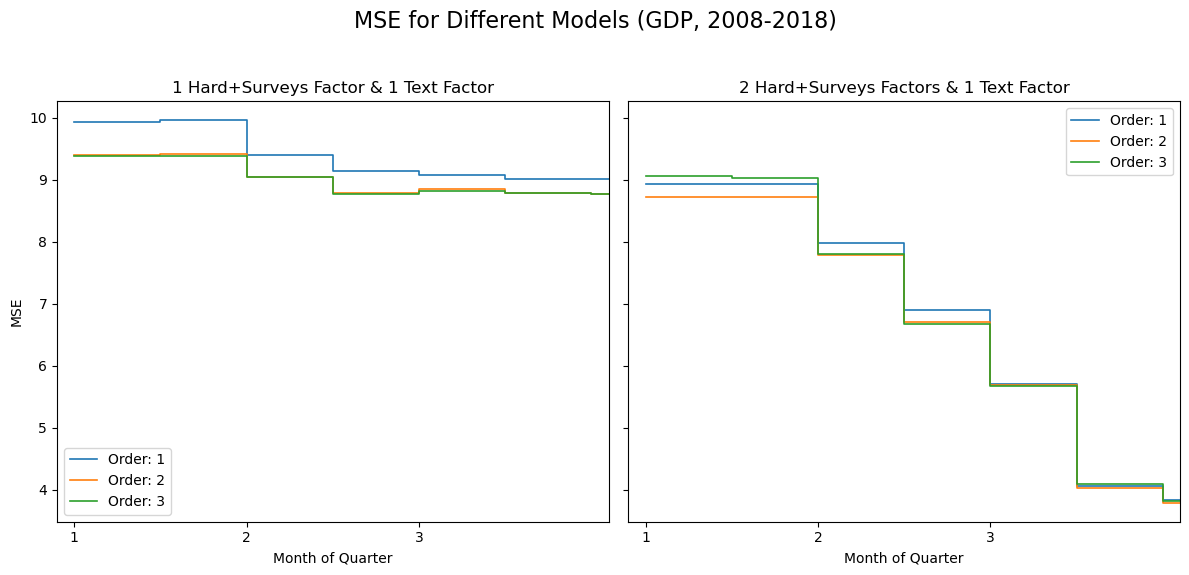

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'GDP'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


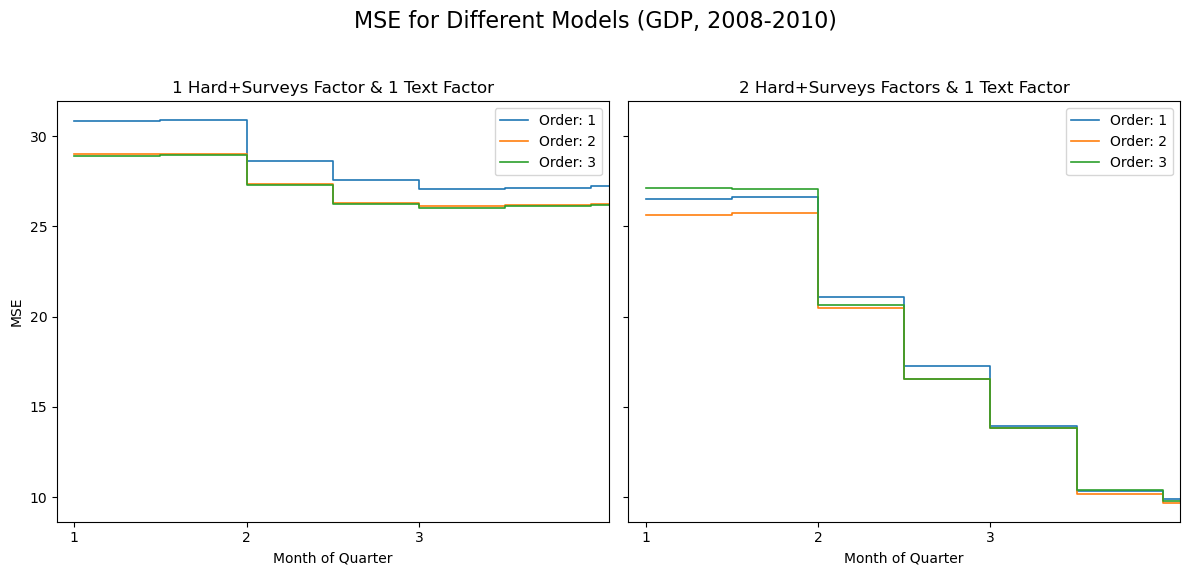

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


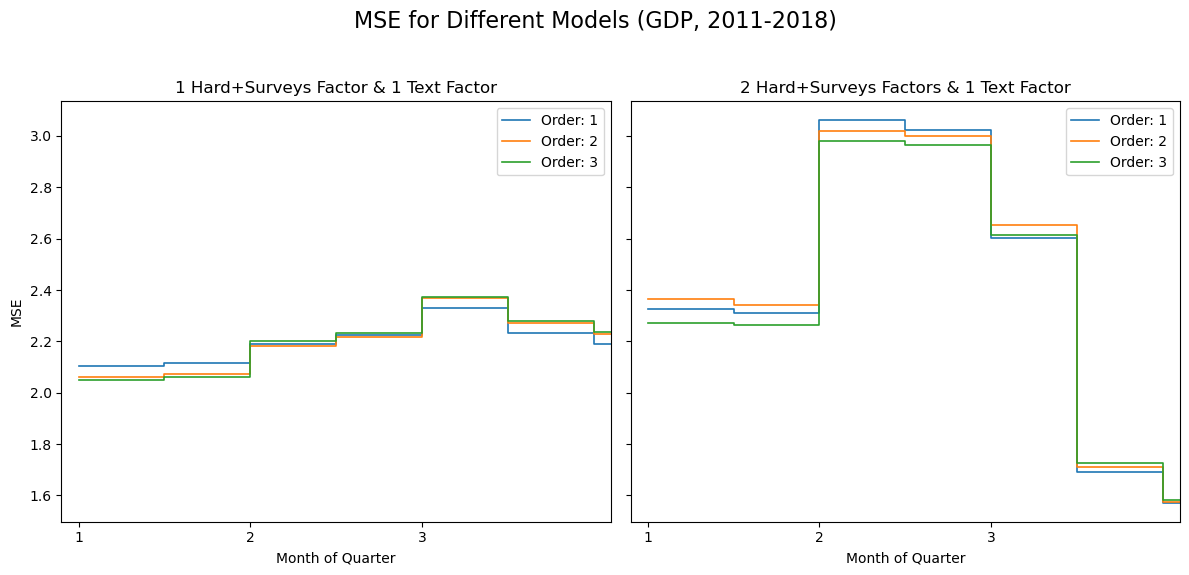

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_GDP_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


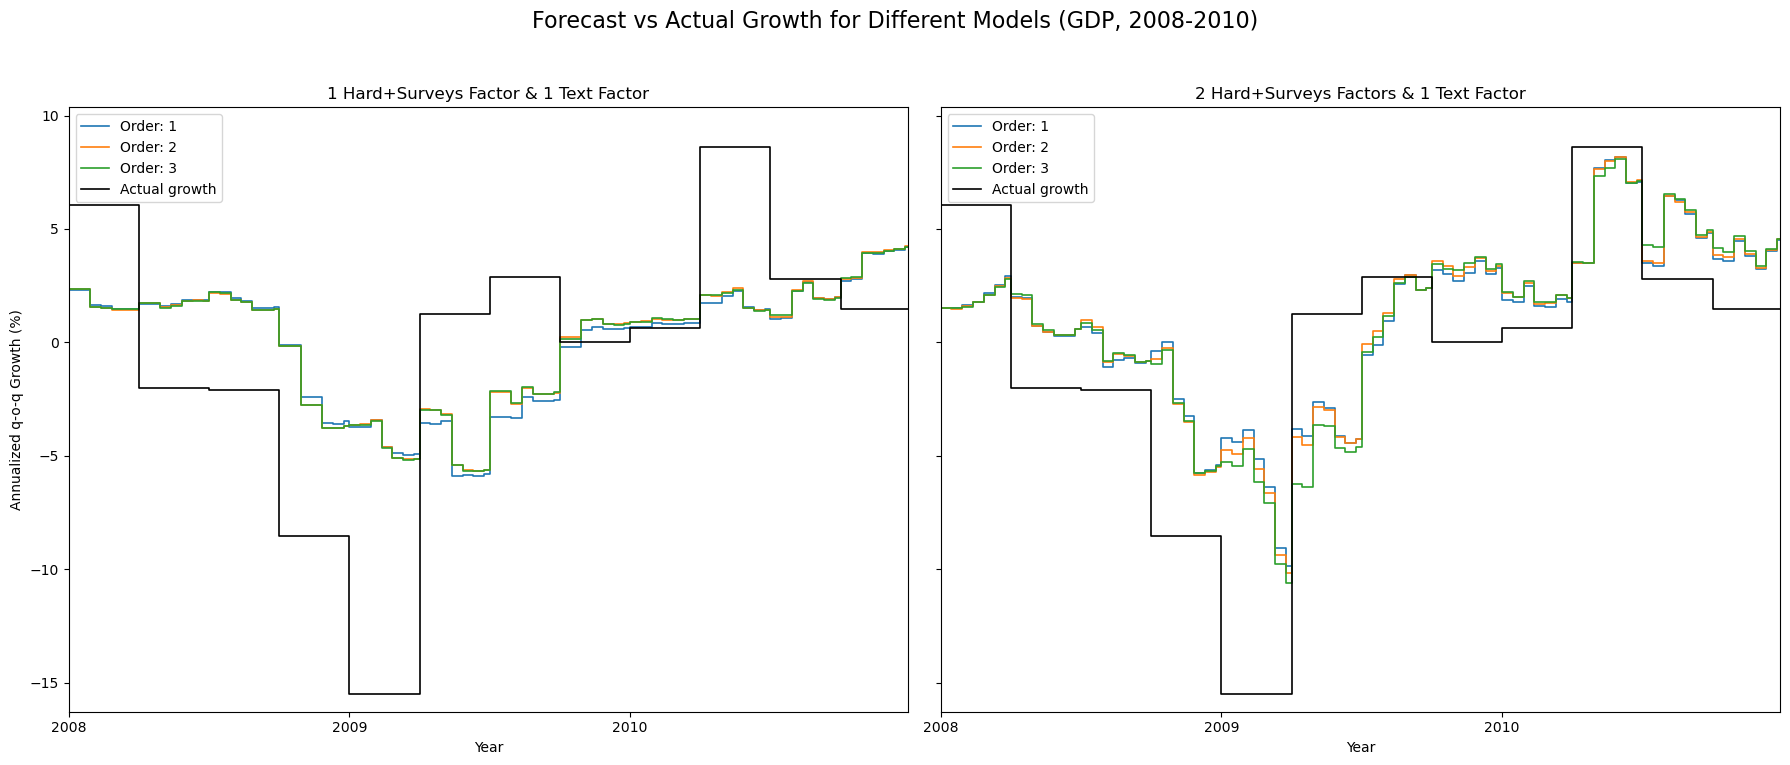

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


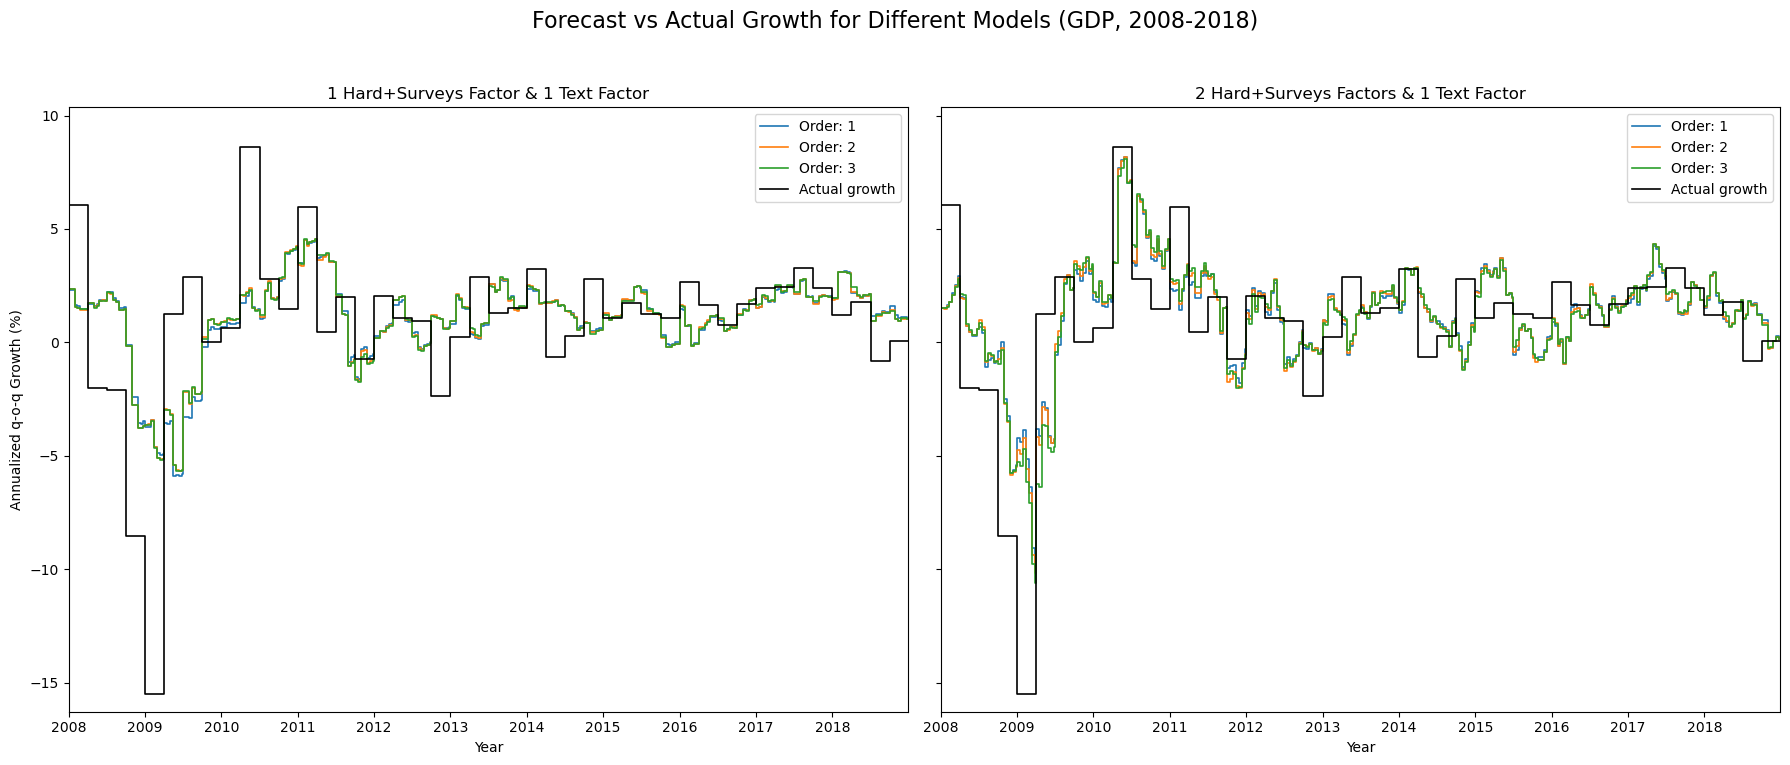

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


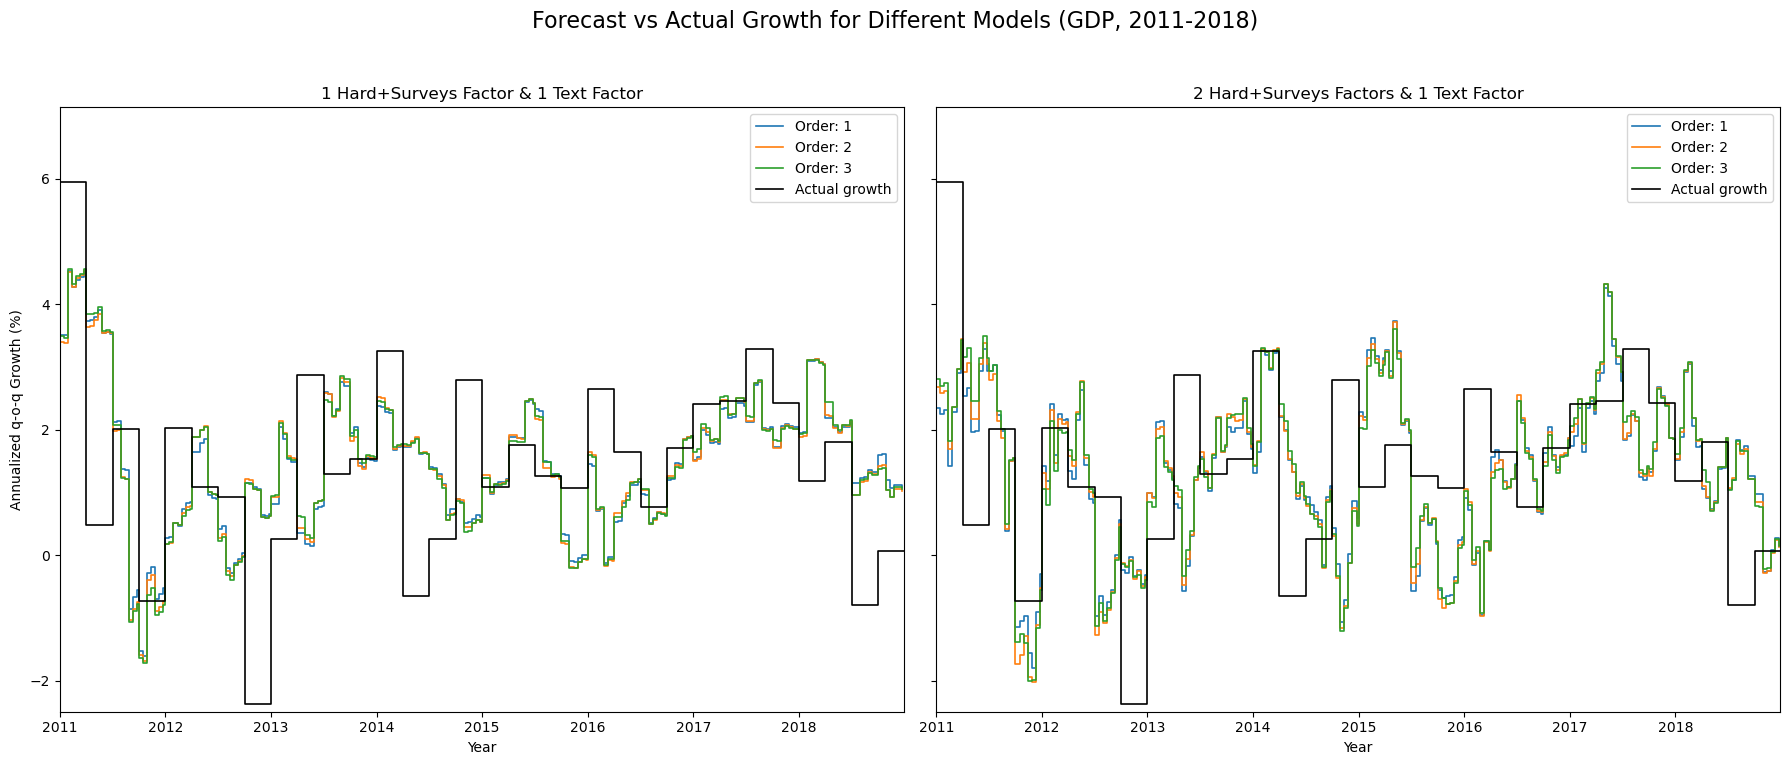

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_GDP_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()